# Combining Observations

Let's start by setting up the notebook (we'll repeat all previous analysis for reference)

In [1]:
from sklearn.neighbors import KernelDensity
from util import nab
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
data_folder = os.path.join('..', 'data', 'nab')
file_name = os.path.join('realKnownCause', 'nyc_taxi.csv')
data, labels, windows = nab.load_series(file_name, data_folder)

# Train and validation end
train_end = pd.to_datetime('2014-10-24 00:00:00')
val_end = pd.to_datetime('2014-12-10 00:00:00')

# Cost model parameters
c_alrm = 1 # Cost of investigating a false alarm
c_missed = 10 # Cost of missing an anomaly
c_late = 5 # Cost for late detection

# Compute the maximum over the training set
trmax = data[data.index < train_end]['value'].max()
# Normalize
data['value'] = data['value'] / trmax
# Separate the training data
data_tr = data[data.index < train_end]

# Compute the bandhwidth
q1 = data_tr['value'].quantile(0.25)
q3 = data_tr['value'].quantile(0.75)
sigma = data_tr['value'].std()
m =  len(data_tr)
h = 0.9 * min(sigma, (q3-q1) / 1.34) * m**(-0.2)
print(f'KDE bandwidth: {h}')

# Build and fit a density estimator
print('Fitting a KDE estimator')
kde = KernelDensity(kernel='gaussian', bandwidth=h)
kde.fit(data_tr)

# Obtain the log probability density for all the data
print('Generating the alarm signal')
ldens = kde.score_samples(data)
# Convert to a pandas series (add the time index)
signal = pd.Series(index=data.index, data=-ldens)

# Build a cost model
cmodel = nab.ADSimpleCostModel(c_alrm, c_missed, c_late)

# Separate train & validation set (for threshold optimization)
signal_opt = signal[signal.index < val_end]
labels_opt = labels[labels < val_end]
windows_opt = windows[windows['end'] < val_end]
thr_range = np.linspace(0, 10, 100)

# Threshold optimization
print('Optimizing the threshold')
best_thr, best_cost = nab.opt_thr(signal_opt, labels_opt,
                                  windows_opt,  cmodel, thr_range)
print(f'Best threshold: {best_thr}')

KDE bandwidth: 0.03476971577055476
Fitting a KDE estimator
Generating the alarm signal
Optimizing the threshold
Best threshold: 4.747474747474747


## Combining Observations

**An anomaly may be linked to a _sequence_ of observations**

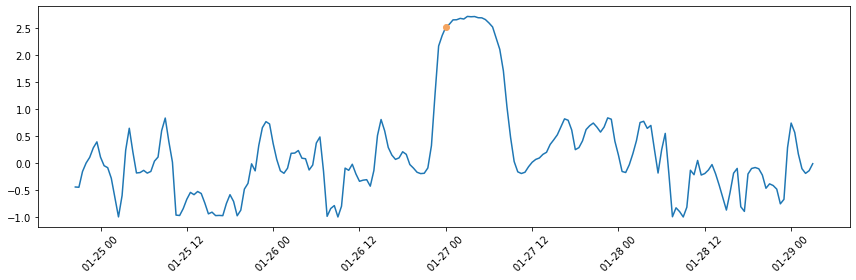

In [2]:
zstart = windows.loc[4]['begin']
zend = windows.loc[4]['end']
zsignal = signal[(signal.index >= zstart) & (signal.index < zend)]
nab.plot_series(zsignal, labels=labels.loc[4:5])

The `loc` field in pandas addresses the index of a `DataFrame` or `Series`

## Combining Observations

**An anomaly may be linked to a _sequence_ of observations**

It's a frequent case in real life:

* Isolated outliers may be due to measurement noise
  - e.g. faulty sensors, human mistakes
* Real anomalies usually _persist_ for a while

**In this case it may be worth to _combine multiple probabilities_**

* We will start by seeing a simple approach
* ...Which makes the assumption that the observations are i.i.d.
  - I.i.d.: Independent and Identically Distributex 

## Combining Observations

* Let $\bf x$ be a random variable corresponding to $n$ subsequent observations
* We can formulate our detection condition as follows:

$$P({\bf x}) \leq \theta^n$$

Since we are assuming i.i.d. observations, we get:

$$\prod_{i=1}^n P(x_i) < \theta^n$$

With a log transformation:

$$\sum_{i=1}^n \log P(x_i) < n \log \theta$$

## Combining Observations

**Finally, we get:**

$$\frac{1}{n} \sum_{i=1}^n \log P(x_i) < \theta$$

Intuitively:

* Considering multiple (independet, identical) observations
* ...It's the same as _smoothing_ our signal using a _moving average_

## Combining Observations

**We can implement the smoothing via a _convolution_:**

In signal theory:

* Given a sequence $\{x_i\}_{i=1}^n$ and a sequence $\{f_j\}_{j=1}^m$ (a _filter_)
* A convolution is an operation that "slides" the filter over the main series
* ...And repeatedly computes dot products to yield a third sequence $\{y_k\}_{k=m}^n$ s.t.:

$$
y_k = f \cdot \left(\begin{array}{ccccc} x_{k-m} & x_{k-m+1} & x_{k-m+2} & \ldots & x_k \end{array}\right)
$$

* I.e. the filter is applied to the first $m$ terms...
* ...Then we move one time step forward and we repeat

**Normally we need at least $m$ values before the first filter application**

* Hence, the output series will be shorter than the input one
* This is depicted by having the $y$ sequence start from index $m$
* There are other ways to handle the series boundaries, but we will not discuss them


## Combining Observations

**We want to compute a moving average, therefore:**

A moving average is just the average of the last few values:

* Let $m$ be the length of the time window for the moving average
* Let us choose as filter: $\left(\frac{1}{m}, \frac{1}{m}, \ldots \right)$

The convolution will compute an output sequence $\{y_k\}_{k=m}^m$, s.t.:

$$
y_k = \frac{1}{m} \sum_{i=k-m}^k x_i
$$

This is exactly what we need!

## Combining Observations

**First we build the filter:**

In [3]:
avg_win_len = 24
flt = np.ones(avg_win_len) / avg_win_len
flt

array([0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
       0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
       0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
       0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
       0.04166667, 0.04166667, 0.04166667, 0.04166667])

**The we apply the convolution:**

In [4]:
smooth_signal = -np.convolve(ldens, flt, mode='valid')
smooth_signal_idx = data.index[avg_win_len-1:]
smooth_signal = pd.Series(index=smooth_signal_idx, data=smooth_signal)

* The convolution needs $n$ observations before it can be first applied
* Hence, we need to _update the index_ for our smoothed signal

## Combining Observations

**Let's plot the smoothed signal**

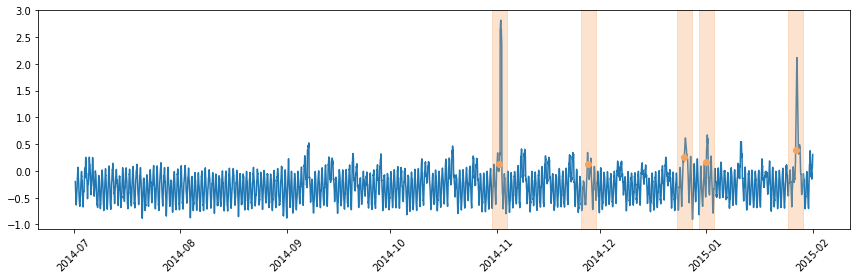

In [5]:
nab.plot_series(smooth_signal, labels=labels, windows=windows)

Some anomalies are now more evident!

## Threshold Effect

**We can now measure the effect of changing the threshold:**

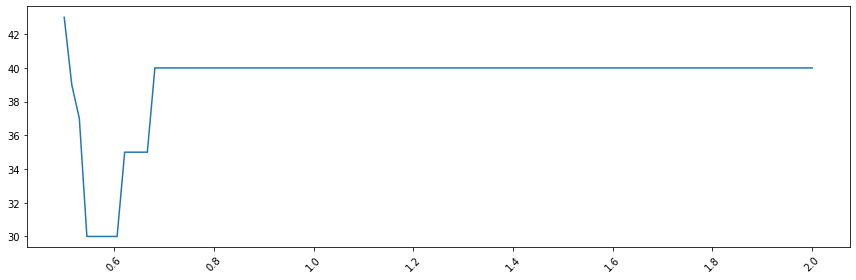

In [6]:
smooth_thr_range = np.linspace(0.5, 2, 100)
smooth_cost_range = [cmodel.cost(smooth_signal, labels, windows, thr)
              for thr in smooth_thr_range]
smooth_cost_range = pd.Series(index=smooth_thr_range, data=smooth_cost_range)
nab.plot_series(smooth_cost_range)

## Threshold Effect

**It is worth to compare it with our orignial cost surface:**

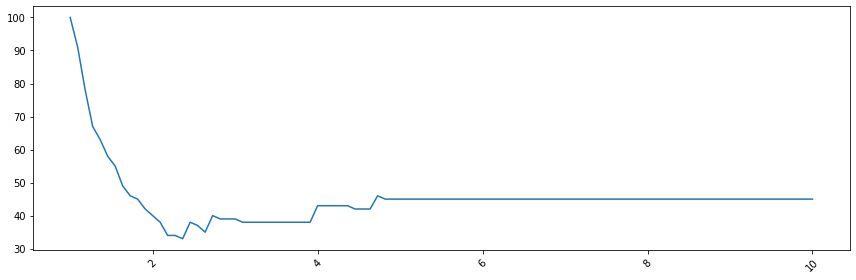

In [7]:
thr_range = np.linspace(1, 10, 100)
cost_range = [cmodel.cost(signal, labels, windows, thr) for thr in thr_range]
cost_range = pd.Series(index=thr_range, data=cost_range)
nab.plot_series(cost_range)

The minimum is a bit lower with the smoothed signal

## Threshold Optimization

**We can now optimize the threshold**

In [8]:
smooth_signal_opt = smooth_signal[smooth_signal.index < val_end]
smooth_best_thr, smooth_best_cost = nab.opt_thr(smooth_signal_opt, labels_opt,
                                  windows_opt,  cmodel, smooth_thr_range)
print(f'Best threshold: {smooth_best_thr}, corresponding cost: {smooth_best_cost}')

Best threshold: 0.5303030303030303, corresponding cost: 15


* Same cost as before on the trainining set
* On the whole dataset, however:

In [9]:
smooth_ctst = cmodel.cost(smooth_signal, labels, windows, smooth_best_thr)
print(f'Cost on the whole dataset {smooth_ctst}')

Cost on the whole dataset 37


* The cost with  our original approach used to be 45

## Some Considerations

**It may worth combining multiple observations:**

* If we notice that the data is noise
* ...Or if we are interested in persistent anomalies

**Combining multiple observations with an i.i.d. assumption...**

* ...Is equivalent to smoothing with a moving average
* ...And the other way round!
* _Warning:_ the assumption may not be valid

**The approach introduces an extra parameter (window length):**

* In principle, we should optimize over that as well
* We skipped that part for sake of simplicity